# Google Analytics Customer Revenue

## Import Libraries 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from scipy import stats
plt.style.use('ggplot')
pd.options.display.max_rows = 999
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
RANDOM_STATE = 42

In [4]:
import json 
from pandas.io.json import json_normalize
import random 
from datetime import datetime

In [5]:
from sklearn import model_selection
from sklearn import metrics


In [3]:
import xgboost as xgb

## Import Data

In [8]:
## Función de lectura 
columns = ['device', 'geoNetwork', 'totals', 'trafficSource'] # Columns with json format

p = 0.25 # Fraction of data to use

def json_read(df):
    data_frame = df
    
    df = pd.read_csv(data_frame, 
                     converters={column: json.loads for column in columns}, 
                     dtype={'fullVisitorId': 'str'}, 
                     skiprows=lambda i: i>0 and random.random() > p)
    
    for column in columns: 
        column_as_df = json_normalize(df[column]) 
        column_as_df.columns = [f"{column}.{subcolumn}" for subcolumn in column_as_df.columns] 
        df = df.drop(column, axis=1).merge(column_as_df, right_index=True, left_index=True)
        
    print(f"Loaded {os.path.basename(data_frame)}. Shape: {df.shape}")
    return df 

In [5]:
file_name = 'train.csv'

In [6]:
%%time
df = json_read(file_name)

Loaded train.csv. Shape: (226269, 54)
Wall time: 45 s


In [7]:
df.head()

channelGrouping      date        fullVisitorId  \
0  Organic Search  20160902   537222803633850821   
1  Organic Search  20160902  4445454811831400414   
2  Organic Search  20160902  9499785259412240342   
3  Organic Search  20160902  9638207207743070032   
4  Organic Search  20160902  3696906537737368442   

                        sessionId  socialEngagementType     visitId  \
0   537222803633850821_1472812602  Not Socially Engaged  1472812602   
1  4445454811831400414_1472805784  Not Socially Engaged  1472805784   
2  9499785259412240342_1472812272  Not Socially Engaged  1472812272   
3  9638207207743070032_1472824614  Not Socially Engaged  1472824614   
4  3696906537737368442_1472856874  Not Socially Engaged  1472856874   

   visitNumber  visitStartTime     device.browser  \
0            1      1472812602             Chrome   
1            1      1472805784  Internet Explorer   
2            1      1472812272            Firefox   
3            1      1472824614             Chrome   
4            1      1472856874             Chrome   

           device.browserVersion  ... trafficSource.keyword  \
0  not available in demo dataset  ...        (not provided)   
1  not available in demo dataset  ...        (not provided)   
2  not available in demo dataset  ...        (not provided)   
3  not available in demo dataset  ...                   NaN   
4  not available in demo dataset  ...        (not provided)   

  trafficSource.adwordsClickInfo.criteriaParameters  \
0                     not available in demo dataset   
1                     not available in demo dataset   
2                     not available in demo dataset   
3                     not available in demo dataset   
4                     not available in demo dataset   

  trafficSource.referralPath  trafficSource.isTrueDirect  \
0                        NaN                         NaN   
1                        NaN                         NaN   
2                        NaN                         NaN   
3                        NaN                         NaN   
4                        NaN                         NaN   

  trafficSource.adwordsClickInfo.page trafficSource.adwordsClickInfo.slot  \
0                                 NaN                                 NaN   
1                                 NaN                                 NaN   
2                                 NaN                                 NaN   
3                                 NaN                                 NaN   
4                                 NaN                                 NaN   

  trafficSource.adwordsClickInfo.gclId  \
0                                  NaN   
1                                  NaN   
2                                  NaN   
3                                  NaN   
4                                  NaN   

  trafficSource.adwordsClickInfo.adNetworkType  \
0                                          NaN   
1                                          NaN   
2                                          NaN   
3                                          NaN   
4                                          NaN   

  trafficSource.adwordsClickInfo.isVideoAd trafficSource.adContent  
0                                      NaN                     NaN  
1                                      NaN                     NaN  
2                                      NaN                     NaN  
3                                      NaN                     NaN  
4                                      NaN                     NaN  

[5 rows x 54 columns]

### Initial EDA

In [8]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226269 entries, 0 to 226268
Columns: 54 entries, channelGrouping to trafficSource.adContent
dtypes: bool(1), int64(4), object(49)
memory usage: 91.7+ MB


In [9]:
index = 'sessionId'
df.set_index(index, inplace=True)
df.drop(['fullVisitorId', 'visitId'], axis=1, inplace=True)

In [10]:
df.head().T

desktop   
geoNetwork.continent                                                     Oceania   
geoNetwork.subContinent                                              Australasia   
geoNetwork.country                                                     Australia   
geoNetwork.region                                                     Queensland   
geoNetwork.metro                                                       (not set)   
geoNetwork.city                                                         Brisbane   
geoNetwork.cityId                                  not available in demo dataset   
geoNetwork.networkDomain                                          bigpond.net.au   
geoNetwork.latitude                                not available in demo dataset   
geoNetwork.longitude                               not available in demo dataset   
geoNetwork.networkLocation                         not available in demo dataset   
totals.visits                                                                  1   
totals.hits                                                                    1   
totals.pageviews                                                               1   
totals.bounces                                                                 1   
totals.newVisits                                                               1   
totals.transactionRevenue                                                    NaN   
trafficSource.campaign                                                 (not set)   
trafficSource.source                                                      google   
trafficSource.medium                                                     organic   
trafficSource.keyword                                             (not provided)   
trafficSource.adwordsClickInfo.criteriaParameters  not available in demo dataset   
trafficSource.referralPath                                                   NaN   
trafficSource.isTrueDirect                                                   NaN   
trafficSource.adwordsClickInfo.page                                          NaN   
trafficSource.adwordsClickInfo.slot                                          NaN   
trafficSource.adwordsClickInfo.gclId                                         NaN   
trafficSource.adwordsClickInfo.adNetworkType                                 NaN   
trafficSource.adwordsClickInfo.isVideoAd                                     NaN   
trafficSource.adContent                                                      NaN   

sessionId                                         4445454811831400414_1472805784  \
channelGrouping                                                   Organic Search   
date                                                                    20160902   
socialEngagementType                                        Not Socially Engaged   
visitNumber                                                                    1   
visitStartTime                                                        1472805784   
device.browser                                                 Internet Explorer   
device.browserVersion                              not available in demo dataset   
device.browserSize                                 not available in demo dataset   
device.operatingSystem                                                   Windows   
device.operatingSystemVersion                      not available in demo dataset   
device.isMobile                                                            False   
device.mobileDeviceBranding                        not available in demo dataset   
device.mobileDeviceModel                           not available in demo dataset   
device.mobileInputSelector                         not available in demo dataset   
device.mobileDeviceInfo                            not available in demo dataset   
device.mobileDeviceMarketingName                   not available in demo dataset   
device.flashVersion                     

In [11]:
df.describe(include=np.number).T

count           mean         std            min  \
date           226269.000   20165876.951    4698.109   20160801.000   
visitNumber    226269.000          2.265       9.323          1.000   
visitStartTime 226269.000 1485000576.877 9024035.567 1470035066.000   

                          25%            50%            75%            max  
date             20161027.000   20170108.000   20170421.000   20170801.000  
visitNumber             1.000          1.000          1.000        394.000  
visitStartTime 1477552118.000 1483907927.000 1492770143.000 1501656981.000

In [12]:
df.describe(exclude=np.number).T

count unique  \
channelGrouping                                    226269      8   
socialEngagementType                               226269      1   
device.browser                                     226269     38   
device.browserVersion                              226269      1   
device.browserSize                                 226269      1   
device.operatingSystem                             226269     16   
device.operatingSystemVersion                      226269      1   
device.isMobile                                    226269      2   
device.mobileDeviceBranding                        226269      1   
device.mobileDeviceModel                           226269      1   
device.mobileInputSelector                         226269      1   
device.mobileDeviceInfo                            226269      1   
device.mobileDeviceMarketingName                   226269      1   
device.flashVersion                                226269      1   
device.language                                    226269      1   
device.screenColors                                226269      1   
device.screenResolution                            226269      1   
device.deviceCategory                              226269      3   
geoNetwork.continent                               226269      6   
geoNetwork.subContinent                            226269     23   
geoNetwork.country                                 226269    210   
geoNetwork.region                                  226269    370   
geoNetwork.metro                                   226269     90   
geoNetwork.city                                    226269    623   
geoNetwork.cityId                                  226269      1   
geoNetwork.networkDomain                           226269  12798   
geoNetwork.latitude                                226269      1   
geoNetwork.longitude                               226269      1   
geoNetwork.networkLocation                         226269      1   
totals.visits                                      226269      1   
totals.hits                                        226269    199   
totals.pageviews                                   226237    152   
totals.bounces                                     112673      1   
totals.newVisits                                   175941      1   
totals.transactionRevenue                            2922   1741   
trafficSource.campaign                             226269     10   
trafficSource.source                               226269    240   
trafficSource.medium                               226269      7   
trafficSource.keyword                              100099   1265   
trafficSource.adwordsClickInfo.criteriaParameters  226269      1   
trafficSource.referralPath                          83214    849   
trafficSource.isTrueDirect                          68478      1   
trafficSource.adwordsClickInfo.page                  5335      5   
trafficSource.adwordsClickInfo.slot                  5335      2   
trafficSource.adwordsClickInfo.gclId                 5365   4961   
trafficSource.adwordsClickInfo.adNetworkType         5335      2   
trafficSource.adwordsClickInfo.isVideoAd             5335      1   
trafficSource.adContent                              2721     36   

                                                                                                 top  \
channelGrouping                                                                       Organic Search   
socialEngagementType                                                            Not Socially Engaged   
device.browser                                                                                Chrome   
device.browserVersion                                                  not available in demo dataset   
device.browserSize                                                     not available in demo dataset   
device.operatingSystem                                                                       Wi

In [13]:
#constant_columns = []
#for column in df.columns:
#    if df[column].nunique() == 1:
#        constant_columns.append(column)

In [14]:
constant_columns = [column for column in df.columns if df[column].nunique() == 1] ## List Comprehension 

In [15]:
constant_columns

['socialEngagementType',
 'device.browserVersion',
 'device.browserSize',
 'device.operatingSystemVersion',
 'device.mobileDeviceBranding',
 'device.mobileDeviceModel',
 'device.mobileInputSelector',
 'device.mobileDeviceInfo',
 'device.mobileDeviceMarketingName',
 'device.flashVersion',
 'device.language',
 'device.screenColors',
 'device.screenResolution',
 'geoNetwork.cityId',
 'geoNetwork.latitude',
 'geoNetwork.longitude',
 'geoNetwork.networkLocation',
 'totals.visits',
 'totals.bounces',
 'totals.newVisits',
 'trafficSource.adwordsClickInfo.criteriaParameters',
 'trafficSource.isTrueDirect',
 'trafficSource.adwordsClickInfo.isVideoAd']

In [16]:
df.drop(constant_columns, axis=1, inplace=True)

In [17]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 226269 entries, 537222803633850821_1472812602 to 5123779100307500332_1483554750
Columns: 28 entries, channelGrouping to trafficSource.adContent
dtypes: bool(1), int64(3), object(24)
memory usage: 48.6+ MB


## Target Analysis

In [18]:
TARGET = 'totals.transactionRevenue'

In [19]:
df[TARGET].describe()

count         2922
unique        1741
top       16990000
freq            64
Name: totals.transactionRevenue, dtype: object

In [20]:
df[df[TARGET].notnull()].head().T

sessionId                                    8885051388942907862_1472827393  \
channelGrouping                                                    Referral   
date                                                               20160902   
visitNumber                                                               7   
visitStartTime                                                   1472827393   
device.browser                                                       Chrome   
device.operatingSystem                                                Linux   
device.isMobile                                                       False   
device.deviceCategory                                               desktop   
geoNetwork.continent                                               Americas   
geoNetwork.subContinent                                    Northern America   
geoNetwork.country                                            United States   
geoNetwork.region                                                  New York   
geoNetwork.metro                                                New York NY   
geoNetwork.city                                                    New York   
geoNetwork.networkDomain                                          (not set)   
totals.hits                                                              13   
totals.pageviews                                                         11   
totals.transactionRevenue                                          68030000   
trafficSource.campaign                                            (not set)   
trafficSource.source                                    mall.googleplex.com   
trafficSource.medium                                               referral   
trafficSource.keyword                                                   NaN   
trafficSource.referralPath                                                /   
trafficSource.adwordsClickInfo.page                                     NaN   
trafficSource.adwordsClickInfo.slot                                     NaN   
trafficSource.adwordsClickInfo.gclId                                    NaN   
trafficSource.adwordsClickInfo.adNetworkType                            NaN   
trafficSource.adContent                                                 NaN   

sessionId                                        0185467632009737931_1472846398  \
channelGrouping                                                        Referral   
date                                                                   20160902   
visitNumber                                                                   6   
visitStartTime                                                       1472846398   
device.browser                                                           Chrome   
device.operatingSystem                                                  Windows   
device.isMobile                                                           False   
device.deviceCategory                                                   desktop   
geoNetwork.continent                                                   Americas   
geoNetwork.subContinent                                        Northern America   
geoNetwork.country                                                United States   
geoNetwork.region                                                    California   
geoNetwork.metro                              San Francisco-Oakland-San Jose CA   
geoNetwork.city                                                   Mountain View   
geoNetwork.networkDomain                                              (not set)   
totals.hits                                                                  13   
totals.pageviews                                                             12   
totals.transactionRevenue                                              26250000   
trafficSource.campaign                                                (not set)   
trafficSource.source                            

Cosas raras: Es tipo Objeto; Sólo tiene 569 valores; tiene ceros por detrás.
 

In [21]:
df[TARGET] = df[TARGET].astype(float)

In [22]:
df[df[TARGET].notnull()].head(20)

Referral  20170623            3   
3412601168298155096_1498263251     Paid Search  20170623            1   
3508419666243874603_1498242081        Referral  20170623            4   
6416811485882520793_1498240051         Display  20170623            2   
4692146566453742608_1498243020  Organic Search  20170623            1   
4127513140005445280_1498218912        Referral  20170623            4   

                                visitStartTime device.browser  \
sessionId                                                       
8885051388942907862_1472827393      1472827393         Chrome   
0185467632009737931_1472846398      1472846398         Chrome   
7147112211830167925_1472853332      1472853332         Chrome   
6664733704830724714_1472853995      1472853995         Chrome   
6045930241388777741_1472825504      1472825504         Chrome   
747690048733385763_1472823219       1472823219         Safari   
8516473451212465925_1472845932      1472845932         Chrome   
3741689406060673010_1472858035      1472858035         Chrome   
7168226225550508027_1485452166      1485452166         Chrome   
205818826345710444_1485483505       1485483505         Chrome   
6388824250276633832_1485474460      1485474460         Chrome   
2402527199731150932_1485453756      1485453756         Chrome   
0463325773564352787_1485475748      1485475748         Chrome   
0750845334721949296_1498226004      1498226004         Chrome   
4064008221273566105_1498245824      1498245824         Chrome   
3412601168298155096_1498263251      1498263251         Chrome   
3508419666243874603_1498242081      1498242081         Chrome   
6416811485882520793_1498240051      1498240051         Chrome   
4692146566453742608_1498243020      1498243020         Chrome   
4127513140005445280_1498218912      1498218912         Chrome   

                               device.operatingSystem  device.isMobile  \
sessionId                                                                
8885051388942907862_1472827393                  Linux            False   
0185467632009737931_1472846398                Windows            False   
7147112211830167925_1472853332                Android             True   
6664733704830724714_1472853995              Chrome OS            False   
6045930241388777741_1472825504                Windows            False   
747690048733385763_1472823219               Macintosh            False   
8516473451212465925_1472845932              Macintosh            False   
3741689406060673010_1472858035              Chrome OS            False   
7168226225550508027_1485452166              Macintosh            False   
205818826345710444_1485483505                 Windows            False   
6388824250276633832_1485474460              Macintosh            False   
2402527199731150932_1485453756              Chrome OS            False   
0463325773564352787_1485475748              Macintosh            False   
0750845334721949296_1498226004              Macintosh            False   
4064008221273566105_1498245824              Macintosh            False   
3412601168298155096_1498263251                Windows            False   
3508419666243874603_1498242081              Macintosh            False   
6416811485882520793_1498240051              Macintosh            False   
4692146566453742608_1498243020              Macintosh            False   
4127513140005445280_1498218912              Macintosh            False   

                               device.deviceCategory geoNetwork.continent  \
sessionId                                                                   
8885051388942907862_1472827393               desktop             Americas   
0185467632009737931_1472846398               desktop             Americas   
7147112211830167925_1472853332                mobile             Americas   
6664733704830724714_1472853995               desktop             Americas   
6045930241388777741_1472825504               desktop             Americas   


In [23]:
df[TARGET].fillna(0.0, inplace=True)

In [24]:
df[TARGET].describe().T

count        226269.000
mean        1713537.913
std        67201254.822
min               0.000
25%               0.000
50%               0.000
75%               0.000
max     23129500000.000
Name: totals.transactionRevenue, dtype: float64

In [25]:
df[TARGET] = df[TARGET]/1000000

In [26]:
df[TARGET].describe().T

count   226269.000
mean         1.714
std         67.201
min          0.000
25%          0.000
50%          0.000
75%          0.000
max      23129.500
Name: totals.transactionRevenue, dtype: float64

In [27]:
df[df[TARGET] > 0][TARGET].describe().T

count    2922.000
mean      132.690
std       576.573
min         0.160
25%        23.970
50%        47.980
75%       103.907
max     23129.500
Name: totals.transactionRevenue, dtype: float64

In [28]:
df['totals.withTransactions'] = (df[TARGET] > 0).astype(int)

In [29]:
df[df['totals.withTransactions'] == 1][TARGET].describe().T

count    2922.000
mean      132.690
std       576.573
min         0.160
25%        23.970
50%        47.980
75%       103.907
max     23129.500
Name: totals.transactionRevenue, dtype: float64

In [30]:
df['totals.withTransactions'].count()

226269

In [31]:
df['totals.withTransactions'].sum()

2922

In [32]:
df['totals.withTransactions'].mean()

0.012913832650517747

In [33]:
transacciones_totales = df['totals.withTransactions'].count()
transacciones_con_compra = df['totals.withTransactions'].sum()
porcentaje_con_compra = df['totals.withTransactions'].mean()
print('De un total de {} visitas, {} tienen compra, representando un {:.2f} del total'.format(transacciones_totales, transacciones_con_compra, 100 * porcentaje_con_compra))

De un total de 226269 visitas, 2922 tienen compra, representando un 1.29 del total


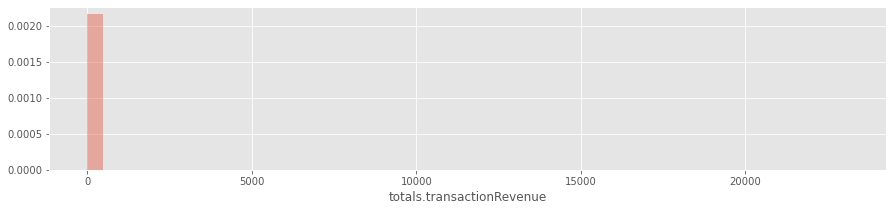

In [34]:
plt.figure(figsize=(15,3))
sns.distplot(
    df[TARGET]
)

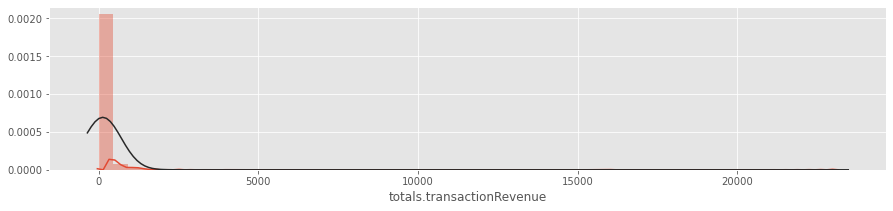

In [35]:
plt.figure(figsize=(15,3))
sns.distplot(
    df[df['totals.withTransactions'] == 1][TARGET],
    fit = stats.norm
)

In [36]:
df['totals.transactionRevenueLN'] = df['totals.transactionRevenue'].apply(np.log1p)

In [37]:
df[df['totals.withTransactions'] == 1].head().T

sessionId                                    8885051388942907862_1472827393  \
channelGrouping                                                    Referral   
date                                                               20160902   
visitNumber                                                               7   
visitStartTime                                                   1472827393   
device.browser                                                       Chrome   
device.operatingSystem                                                Linux   
device.isMobile                                                       False   
device.deviceCategory                                               desktop   
geoNetwork.continent                                               Americas   
geoNetwork.subContinent                                    Northern America   
geoNetwork.country                                            United States   
geoNetwork.region                                                  New York   
geoNetwork.metro                                                New York NY   
geoNetwork.city                                                    New York   
geoNetwork.networkDomain                                          (not set)   
totals.hits                                                              13   
totals.pageviews                                                         11   
totals.transactionRevenue                                            68.030   
trafficSource.campaign                                            (not set)   
trafficSource.source                                    mall.googleplex.com   
trafficSource.medium                                               referral   
trafficSource.keyword                                                   NaN   
trafficSource.referralPath                                                /   
trafficSource.adwordsClickInfo.page                                     NaN   
trafficSource.adwordsClickInfo.slot                                     NaN   
trafficSource.adwordsClickInfo.gclId                                    NaN   
trafficSource.adwordsClickInfo.adNetworkType                            NaN   
trafficSource.adContent                                                 NaN   
totals.withTransactions                                                   1   
totals.transactionRevenueLN                                           4.235   

sessionId                                        0185467632009737931_1472846398  \
channelGrouping                                                        Referral   
date                                                                   20160902   
visitNumber                                                                   6   
visitStartTime                                                       1472846398   
device.browser                                                           Chrome   
device.operatingSystem                                                  Windows   
device.isMobile                                                           False   
device.deviceCategory                                                   desktop   
geoNetwork.continent                                                   Americas   
geoNetwork.subContinent                                        Northern America   
geoNetwork.country                                                United States   
geoNetwork.region                                                    California   
geoNetwork.metro                              San Francisco-Oakland-San Jose CA   
geoNetwork.city                                                   Mountain View   
geoNetwork.networkDomain                                              (not set)   
totals.hits                                                                  13   
totals.pageviews                                                             12   
totals.transactionRevenue                               

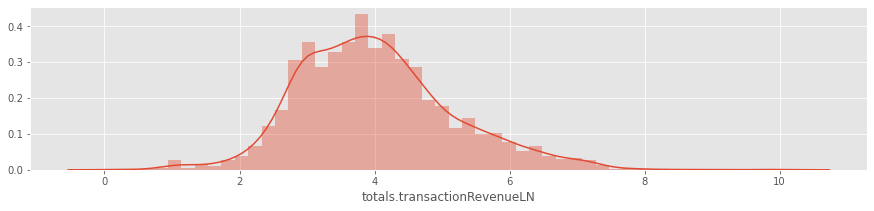

In [38]:
plt.figure(figsize=(15,3))
sns.distplot(
    df[df['totals.withTransactions'] == 1]['totals.transactionRevenueLN']
)

Podemos hacer el análisis estadístico de la normalidad

In [39]:
from scipy import stats

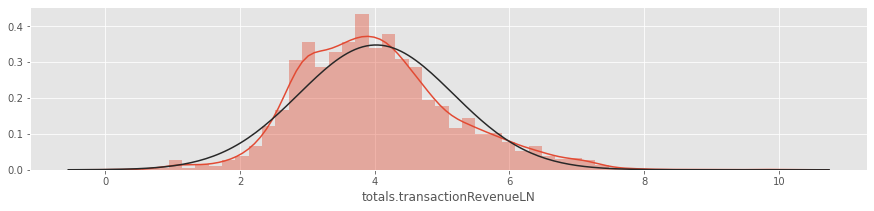

In [40]:
plt.figure(figsize=(15,3))
sns.distplot(
    df[df['totals.withTransactions'] == 1]['totals.transactionRevenueLN'],
    fit = stats.norm
)

#### DeviceBrowser

In [41]:
df['device.browser'].describe()

count     226269
unique        38
top       Chrome
freq      155189
Name: device.browser, dtype: object

Pintamos los valores

In [42]:
df['device.browser'].value_counts(dropna=False, normalize=True) * 100

Chrome                     68.586
Safari                     20.164
Firefox                     4.174
Internet Explorer           2.153
Edge                        1.120
Android Webview             0.879
Safari (in-app)             0.755
Opera Mini                  0.666
Opera                       0.616
UC Browser                  0.278
YaBrowser                   0.230
Coc Coc                     0.088
Amazon Silk                 0.059
Android Browser             0.058
Mozilla Compatible Agent    0.046
MRCHROME                    0.030
Maxthon                     0.024
BlackBerry                  0.019
Nintendo Browser            0.015
Puffin                      0.011
Nokia Browser               0.008
Iron                        0.004
LYF_LS_4002_12              0.003
SeaMonkey                   0.003
Apple-iPhone7C2             0.002
Seznam                      0.001
0                           0.001
no-ua                       0.001
osee2unifiedRelease         0.001
Nichrome      

In [43]:
top_browsers = df['device.browser'].value_counts().head(5)

In [44]:
top_browsers

Chrome               155189
Safari                45626
Firefox                9444
Internet Explorer      4872
Edge                   2534
Name: device.browser, dtype: int64

In [45]:
top_browsers_list = top_browsers.index.to_list()

In [46]:
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge']

In [47]:
top_browsers_list

['Chrome', 'Safari', 'Firefox', 'Internet Explorer', 'Edge']

In [48]:
df['device.browser'] = pd.Categorical(df['device.browser'], categories=top_browsers_list)

In [49]:
top_browsers_list.append('Others')

In [50]:
df['device.browser'].fillna('Others', inplace=True)

ValueError: fill value must be in categories

In [51]:
df['device.browser'].value_counts(normalize=True)

Chrome              0.713
Safari              0.210
Firefox             0.043
Internet Explorer   0.022
Edge                0.012
Name: device.browser, dtype: float64

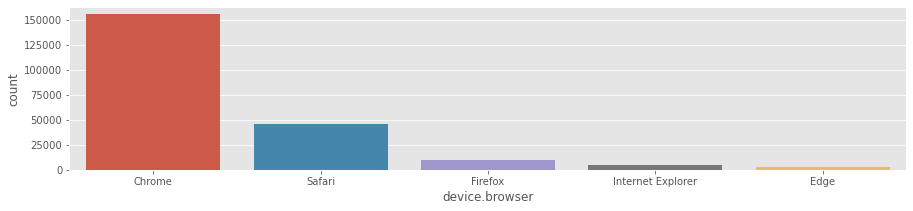

In [52]:
plt.figure(figsize=(15,3))
sns.countplot(
    df['device.browser']
)

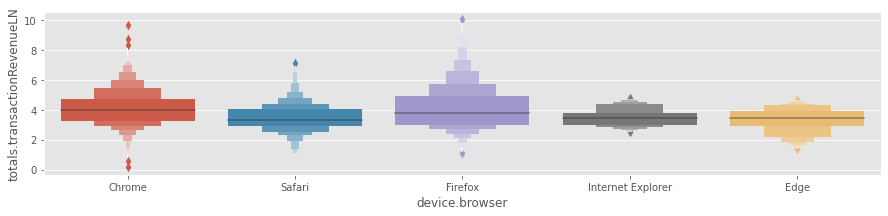

In [53]:
plt.figure(figsize=(15,3))
sns.boxenplot(
    data = df[df['totals.withTransactions'] == 1], 
    x = 'device.browser',
    y = 'totals.transactionRevenueLN'
)

In [54]:
def set_others(df, column, num_values):
    top_categories = df[column].value_counts().head(num_values)
    top_categories_list = top_categories.index.to_list()
    top_categories_list.append('Others')
    return pd.Categorical(df[column], categories=top_categories_list).fillna('Others')

In [55]:
def plot_categories(df, column, target):
    plt.figure(figsize=(15,8))

    plt.subplot(2,1,1)
    sns.countplot(
        df[column]
    )

    plt.subplot(2,1,2)
    sns.boxenplot(
        data = df[df[target] > 0], 
        x = column,
        y = target
    )

    plt.xticks(rotation=45)
    
    plt.show()

#### SO

In [56]:
df['device.operatingSystem'].value_counts(dropna=False, normalize=True) * 100

Windows         38.738
Macintosh       28.079
Android         13.702
iOS             11.935
Linux            3.904
Chrome OS        2.900
(not set)        0.524
Windows Phone    0.133
Samsung          0.028
BlackBerry       0.023
Firefox OS       0.011
Nintendo Wii     0.011
Xbox             0.006
Nintendo WiiU    0.004
FreeBSD          0.001
OpenBSD          0.000
Name: device.operatingSystem, dtype: float64

In [57]:
df['device.operatingSystem'] = set_others(df, 'device.operatingSystem', 6)

In [58]:
df['device.operatingSystem'].value_counts(dropna=False, normalize=True) * 100

Windows     38.738
Macintosh   28.079
Android     13.702
iOS         11.935
Linux        3.904
Chrome OS    2.900
Others       0.741
Name: device.operatingSystem, dtype: float64

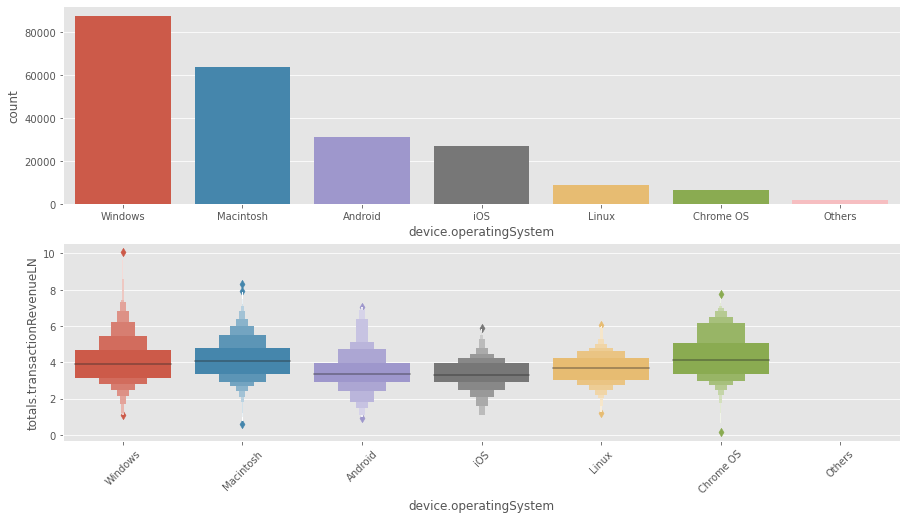

In [59]:
plot_categories(df, 'device.operatingSystem', 'totals.transactionRevenueLN')

#### Hits


In [60]:
df['totals.hits'].describe()

count     226269
unique       199
top            1
freq      111696
Name: totals.hits, dtype: object

In [61]:
df['totals.hits'].value_counts(dropna=False)

1      111696
2       34637
3       17785
4       10696
5        7756
6        5990
7        4817
8        3899
9        3232
10       2680
11       2247
12       1975
13       1682
14       1552
15       1385
16       1198
17       1009
18        959
19        811
20        698
21        668
22        638
23        568
24        538
25        496
26        435
27        378
30        353
28        341
29        320
31        287
32        272
34        229
33        226
35        212
36        188
38        180
39        179
37        171
40        145
41        139
42        137
43        127
46        109
45        104
44        100
47         94
48         91
50         84
49         79
51         71
52         71
53         66
60         59
54         59
62         54
56         54
55         51
57         49
61         47
58         46
59         46
68         38
67         35
73         34
63         30
64         30
65         30
75         28
71         27
70         26
69    

In [62]:
df['totals.hits'] = df['totals.hits'].astype(int)

In [63]:
df['totals.hits'].describe()

count   226269.000
mean         4.603
std          9.861
min          1.000
25%          1.000
50%          2.000
75%          4.000
max        500.000
Name: totals.hits, dtype: float64

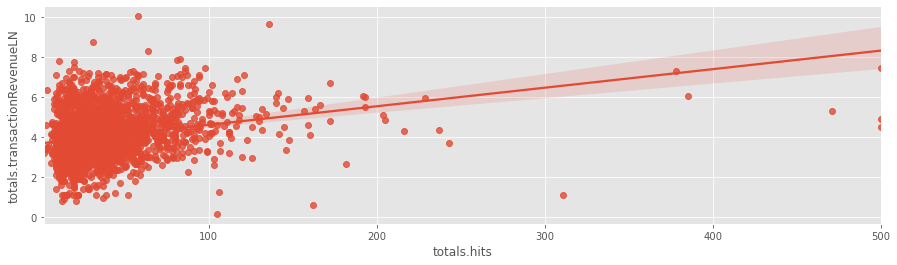

In [64]:
plt.figure(figsize=(15,4))
sns.regplot(
    data=df[df['totals.withTransactions'] == 1],
    x = 'totals.hits',
    y = 'totals.transactionRevenueLN'
)

In [65]:
# def aplica_logaritmo(x):
#    return np.log1p(x)

#df['totals.hitsLN'] = df['totals.hits'].apply(aplica_logaritmo)

In [66]:
df['totals.hitsLN'] = df['totals.hits'].apply(lambda x: np.log1p(x))

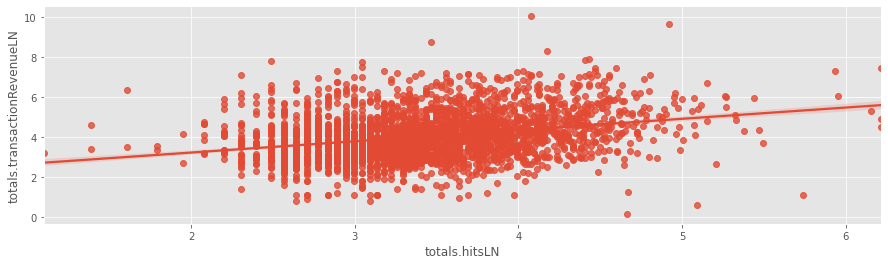

In [67]:
plt.figure(figsize=(15,4))
sns.regplot(
    data=df[df['totals.withTransactions'] == 1],
    x = 'totals.hitsLN',
    y = 'totals.transactionRevenueLN'
)

#### Date

In [68]:
df['date'].describe()

count     226269.000
mean    20165876.951
std         4698.109
min     20160801.000
25%     20161027.000
50%     20170108.000
75%     20170421.000
max     20170801.000
Name: date, dtype: float64

In [69]:
df['date'].head()

sessionId
537222803633850821_1472812602     20160902
4445454811831400414_1472805784    20160902
9499785259412240342_1472812272    20160902
9638207207743070032_1472824614    20160902
3696906537737368442_1472856874    20160902
Name: date, dtype: int64

In [70]:
df['date'] = pd.to_datetime(df['date'], format='%Y%m%d')

In [71]:
df['date'].head()

sessionId
537222803633850821_1472812602    2016-09-02
4445454811831400414_1472805784   2016-09-02
9499785259412240342_1472812272   2016-09-02
9638207207743070032_1472824614   2016-09-02
3696906537737368442_1472856874   2016-09-02
Name: date, dtype: datetime64[ns]

In [72]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekDay'] = df['date'].dt.weekday
df['quarter'] = df['date'].dt.quarter
df['week'] = df['date'].dt.week

In [73]:
df.head().T

sessionId                                    537222803633850821_1472812602  \
channelGrouping                                             Organic Search   
date                                                   2016-09-02 00:00:00   
visitNumber                                                              1   
visitStartTime                                                  1472812602   
device.browser                                                      Chrome   
device.operatingSystem                                             Windows   
device.isMobile                                                      False   
device.deviceCategory                                              desktop   
geoNetwork.continent                                               Oceania   
geoNetwork.subContinent                                        Australasia   
geoNetwork.country                                               Australia   
geoNetwork.region                                               Queensland   
geoNetwork.metro                                                 (not set)   
geoNetwork.city                                                   Brisbane   
geoNetwork.networkDomain                                    bigpond.net.au   
totals.hits                                                              1   
totals.pageviews                                                         1   
totals.transactionRevenue                                            0.000   
trafficSource.campaign                                           (not set)   
trafficSource.source                                                google   
trafficSource.medium                                               organic   
trafficSource.keyword                                       (not provided)   
trafficSource.referralPath                                             NaN   
trafficSource.adwordsClickInfo.page                                    NaN   
trafficSource.adwordsClickInfo.slot                                    NaN   
trafficSource.adwordsClickInfo.gclId                                   NaN   
trafficSource.adwordsClickInfo.adNetworkType                           NaN   
trafficSource.adContent                                                NaN   
totals.withTransactions                                                  0   
totals.transactionRevenueLN                                          0.000   
totals.hitsLN                                                        0.693   
year                                                                  2016   
month                                                                    9   
day                                                                      2   
weekDay                                                                  4   
quarter                                                                  3   
week                                                                    35   

sessionId                                    4445454811831400414_1472805784  \
channelGrouping                                              Organic Search   
date                                                    2016-09-02 00:00:00   
visitNumber                                                               1   
visitStartTime                                                   1472805784   
device.browser                                            Internet Explorer   
device.operatingSystem                                              Windows   
device.isMobile                                                       False   
device.deviceCategory                                               desktop   
geoNetwork.continent                                                 Europe   
geoNetwork.subContinent                                      Western Europe   
geoNetwork.country                                                  Austria   
geoNetwork.region                             not available in demo dataset   
geoNetwo

In [74]:
df.drop('date', axis=1, inplace=True)

#### Visit Start Time

In [75]:
df['visitStartTime'].head()

sessionId
537222803633850821_1472812602     1472812602
4445454811831400414_1472805784    1472805784
9499785259412240342_1472812272    1472812272
9638207207743070032_1472824614    1472824614
3696906537737368442_1472856874    1472856874
Name: visitStartTime, dtype: int64

In [76]:
datetime.fromtimestamp(1472880147).minute

22

In [77]:
df['visitHour'] = df['visitStartTime'].apply(lambda x: datetime.fromtimestamp(x).hour)

In [78]:
df['visitHour'].head()

sessionId
537222803633850821_1472812602     12
4445454811831400414_1472805784    10
9499785259412240342_1472812272    12
9638207207743070032_1472824614    15
3696906537737368442_1472856874     0
Name: visitHour, dtype: int64

In [79]:
df.drop('visitStartTime', axis=1, inplace=True)

In [80]:
df_per_hour = df[df['totals.withTransactions'] == 1].pivot_table(index='visitHour', values='totals.transactionRevenueLN', aggfunc=[len, np.mean])

In [81]:
df_per_hour.columns = ['n_instancias', 'mean_transaction_LN']

In [82]:
df_per_hour.sort_values(by='mean_transaction_LN', ascending=False)

n_instancias  mean_transaction_LN
visitHour                                   
12                9.000                5.019
15              111.000                4.391
16              148.000                4.346
17              191.000                4.128
19              247.000                4.122
20              249.000                4.111
21              221.000                4.087
22              206.000                4.063
23              217.000                4.056
14               45.000                4.030
18              199.000                4.004
0               188.000                3.994
8                30.000                3.934
3               115.000                3.898
9                24.000                3.866
4                98.000                3.844
5               112.000                3.825
7                69.000                3.818
1               173.000                3.779
6                93.000                3.772
2               132.000                3.754
13               24.000                3.744
10               10.000                3.518
11               11.000                3.485

In [83]:
transactions_per_hour = df.pivot_table(index='visitHour', values='totals.withTransactions', aggfunc=[len, np.sum, np.mean])

In [84]:
transactions_per_hour.columns = ['n_instances', 'transaction_sum', 'pct_transactions']

In [85]:
transactions_per_hour.sort_values(by='pct_transactions', ascending=False)

n_instances  transaction_sum  pct_transactions
visitHour                                                
23               10547              217             0.021
0                 9337              188             0.020
1                 8731              173             0.020
20               12740              249             0.020
19               12982              247             0.019
21               11617              221             0.019
22               11677              206             0.018
2                 8257              132             0.016
17               12052              191             0.016
18               12577              199             0.016
5                 7727              112             0.014
3                 8101              115             0.014
16               11584              148             0.013
6                 7417               93             0.013
4                 7866               98             0.012
15               10492              111             0.011
7                 7192               69             0.010
14                9133               45             0.005
8                 7617               30             0.004
13                7946               24             0.003
9                 7969               24             0.003
11                7619               11             0.001
10                7710               10             0.001
12                7379                9             0.001

#### Visit Number 

In [86]:
df['visitNumber'].describe()

count   226269.000
mean         2.265
std          9.323
min          1.000
25%          1.000
50%          1.000
75%          1.000
max        394.000
Name: visitNumber, dtype: float64

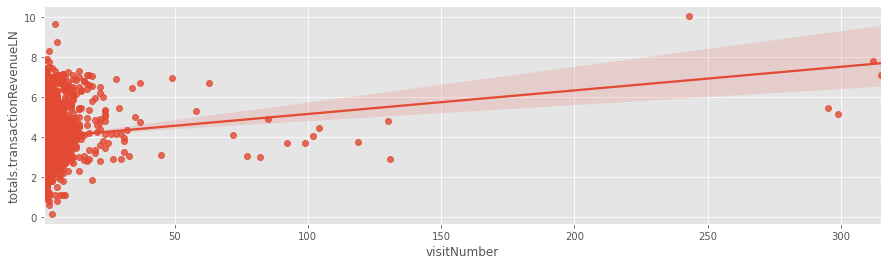

In [87]:
plt.figure(figsize=(15,4))
sns.regplot(
    data=df[df['totals.withTransactions'] == 1],
    x = 'visitNumber',
    y = 'totals.transactionRevenueLN'
)

In [88]:
df['visitNumberLN'] = df['visitNumber'].apply(lambda x: np.log1p(x))

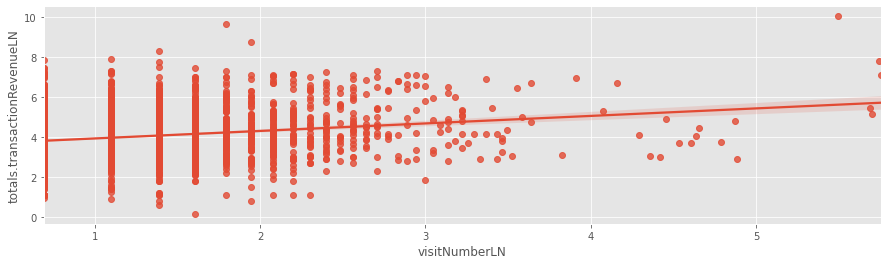

In [89]:
plt.figure(figsize=(15,4))
sns.regplot(
    data=df[df['totals.withTransactions'] == 1],
    x = 'visitNumberLN',
    y = 'totals.transactionRevenueLN'
)

#### Page Views

In [90]:
df['totals.pageviews'].head()

sessionId
537222803633850821_1472812602     1
4445454811831400414_1472805784    1
9499785259412240342_1472812272    1
9638207207743070032_1472824614    1
3696906537737368442_1472856874    1
Name: totals.pageviews, dtype: object

In [91]:
df['totals.pageviews'].value_counts()

1      113161
2       36073
3       18680
4       11368
5        8395
6        6015
7        4904
8        3882
9        3067
10       2502
11       2137
12       1760
13       1571
14       1308
15       1186
16       1033
17        854
18        830
19        669
20        562
21        562
22        468
23        444
24        412
25        366
26        356
27        290
28        263
31        223
29        216
30        193
32        190
35        153
33        153
34        146
36        129
37        111
39         94
38         92
40         76
41         76
45         74
42         68
43         66
48         62
46         56
47         54
44         52
51         51
52         43
50         42
49         40
57         36
54         34
53         31
55         30
56         26
60         25
61         22
59         22
64         22
67         21
58         21
63         18
66         17
72         17
62         16
68         15
71         15
75         14
70         14
73    

In [92]:
df['totals.pageviews'].isnull().sum()

32

In [93]:
df['totals.pageviews'].fillna('0', inplace=True)

In [94]:
df['totals.pageviews'] = df['totals.pageviews'].astype(int)

In [95]:
df['totals.pageviews'].describe()

count   226269.000
mean         3.854
std          7.182
min          0.000
25%          1.000
50%          1.000
75%          4.000
max        469.000
Name: totals.pageviews, dtype: float64

In [96]:
df['totals.pageviewsLN'] = df['totals.pageviews'].apply(lambda x: np.log1p(x))

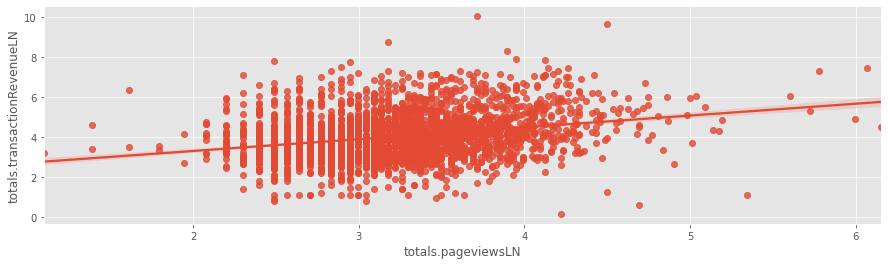

In [97]:
plt.figure(figsize=(15,4))
sns.regplot(
    data=df[df['totals.withTransactions'] == 1],
    x = 'totals.pageviewsLN',
    y = 'totals.transactionRevenueLN'
)

In [98]:
df[['totals.pageviews', 'totals.hits']].head()

totals.pageviews  totals.hits
sessionId                                                    
537222803633850821_1472812602                  1            1
4445454811831400414_1472805784                 1            1
9499785259412240342_1472812272                 1            1
9638207207743070032_1472824614                 1            1
3696906537737368442_1472856874                 1            1

In [99]:
df[['totals.pageviewsLN', 'totals.hitsLN']].corr()

totals.pageviewsLN  totals.hitsLN
totals.pageviewsLN               1.000          0.991
totals.hitsLN                    0.991          1.000

In [100]:
corr = df[['totals.pageviewsLN', 'totals.hitsLN', 'totals.transactionRevenueLN']].corr()
corr.style.background_gradient()
# 'RdBu_r' & 'BrBG' are other good diverging colormaps

#### Channel Grouping 

In [101]:
df['channelGrouping'].describe()

count             226269
unique                 8
top       Organic Search
freq               95296
Name: channelGrouping, dtype: object

In [102]:
df['channelGrouping'].value_counts(dropna=False)

Organic Search    95296
Social            56925
Direct            35621
Referral          26293
Paid Search        6297
Affiliates         4209
Display            1601
(Other)              27
Name: channelGrouping, dtype: int64

In [103]:
df['channelGrouping'].value_counts(normalize=True, dropna=False)

Organic Search   0.421
Social           0.252
Direct           0.157
Referral         0.116
Paid Search      0.028
Affiliates       0.019
Display          0.007
(Other)          0.000
Name: channelGrouping, dtype: float64

In [104]:
df[df['totals.withTransactions'] == 1].pivot_table(index='channelGrouping', values='totals.transactionRevenueLN', aggfunc=[np.mean])

mean
                totals.transactionRevenueLN
channelGrouping                            
(Other)                               2.397
Affiliates                            5.459
Direct                                4.279
Display                               4.740
Organic Search                        3.785
Paid Search                           3.826
Referral                              4.083
Social                                3.536

In [105]:
def explore_values(column_name, df, target):
    value_count = df[column_name].value_counts()
    percentages = df[column_name].value_counts(normalize = True)
    mean_values = df[df[target] > 0].pivot_table(index=column_name, values=target, aggfunc=[np.mean])

    results_df = pd.concat([value_count, percentages, mean_values], axis=1)
    results_df.columns = ['count', 'pct', 'mean_target']

    return results_df.sort_values(by='mean_target', ascending=False)

In [106]:
explore_values('channelGrouping', df, 'totals.transactionRevenueLN')

count   pct  mean_target
Affiliates       4209 0.019        5.459
Display          1601 0.007        4.740
Direct          35621 0.157        4.279
Referral        26293 0.116        4.083
Paid Search      6297 0.028        3.826
Organic Search  95296 0.421        3.785
Social          56925 0.252        3.536
(Other)            27 0.000        2.397

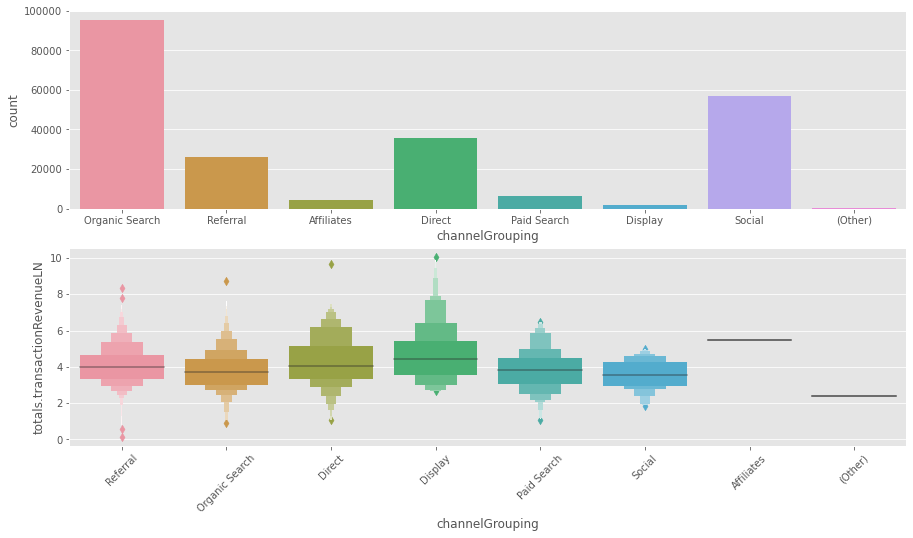

In [107]:
plot_categories(df, 'channelGrouping', 'totals.transactionRevenueLN')

#### isMobile

In [108]:
df['device.isMobile'].describe()

count     226269
unique         2
top        False
freq      166370
Name: device.isMobile, dtype: object

In [109]:
df['device.isMobile'].value_counts(dropna=False)

False    166370
True      59899
Name: device.isMobile, dtype: int64

In [110]:
df['device.isMobile'].head()

sessionId
537222803633850821_1472812602     False
4445454811831400414_1472805784    False
9499785259412240342_1472812272    False
9638207207743070032_1472824614    False
3696906537737368442_1472856874    False
Name: device.isMobile, dtype: bool

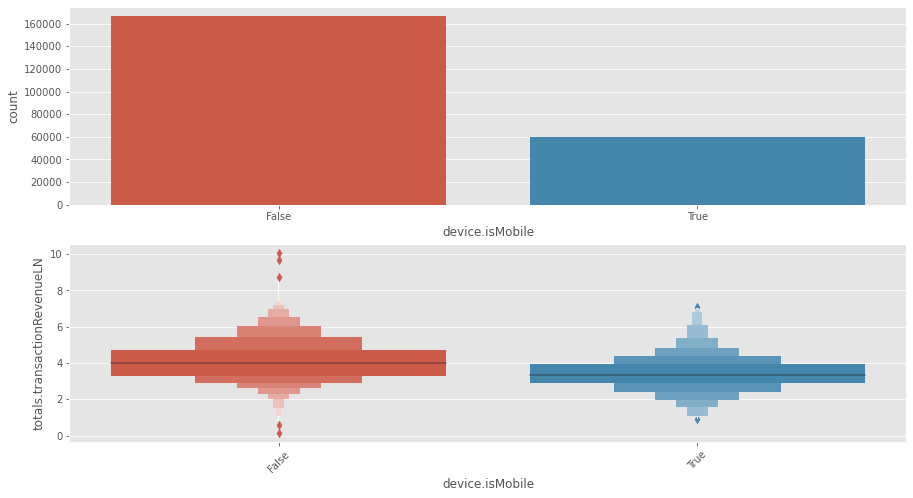

In [111]:
plot_categories(df, 'device.isMobile', 'totals.transactionRevenueLN')

In [112]:
df['device.isMobile'] = (df['device.isMobile'] == 'True').astype(int)

In [113]:
df['device.isMobile'].value_counts()

0    226269
Name: device.isMobile, dtype: int64

#### Device Category

In [114]:
df['device.deviceCategory'].describe()

count      226269
unique          3
top       desktop
freq       166356
Name: device.deviceCategory, dtype: object

In [115]:
df['device.deviceCategory'].value_counts()

desktop    166356
mobile      52187
tablet       7726
Name: device.deviceCategory, dtype: int64

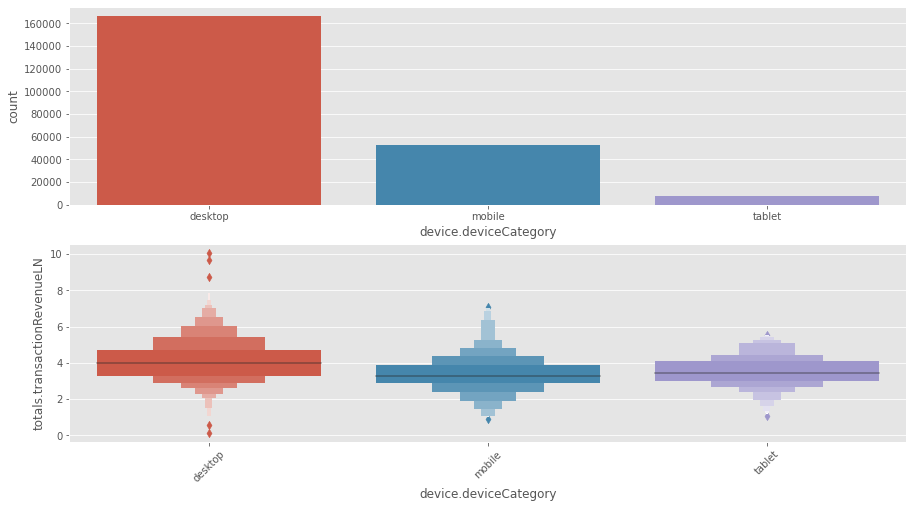

In [116]:
plot_categories(df, 'device.deviceCategory', 'totals.transactionRevenueLN')

#### Continent

In [117]:
df['geoNetwork.continent'].describe()

count       226269
unique           6
top       Americas
freq        112914
Name: geoNetwork.continent, dtype: object

In [118]:
df['geoNetwork.continent'].head()

sessionId
537222803633850821_1472812602      Oceania
4445454811831400414_1472805784      Europe
9499785259412240342_1472812272      Europe
9638207207743070032_1472824614        Asia
3696906537737368442_1472856874    Americas
Name: geoNetwork.continent, dtype: object

In [119]:
df['geoNetwork.continent'].value_counts(dropna=True)

Americas     112914
Asia          56057
Europe        49443
Oceania        3770
Africa         3715
(not set)       370
Name: geoNetwork.continent, dtype: int64

In [120]:
explore_values('geoNetwork.continent', df, 'totals.transactionRevenueLN')

count   pct  mean_target
Africa       3715 0.016        7.493
(not set)     370 0.002        5.431
Oceania      3770 0.017        4.527
Asia        56057 0.248        4.336
Europe      49443 0.219        4.210
Americas   112914 0.499        4.013

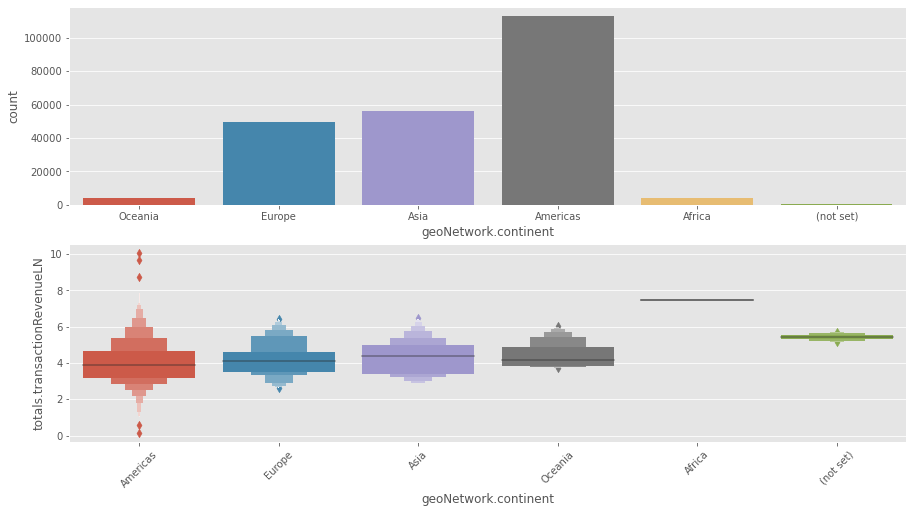

In [121]:
plot_categories(df, 'geoNetwork.continent', 'totals.transactionRevenueLN')

#### Subcontinent

In [122]:
df['geoNetwork.subContinent'].describe()

count               226269
unique                  23
top       Northern America
freq                 97865
Name: geoNetwork.subContinent, dtype: object

In [123]:
explore_values('geoNetwork.subContinent', df, 'totals.transactionRevenueLN')

count   pct  mean_target
Western Africa        678 0.003        7.493
(not set)             370 0.002        5.431
Southern Asia       14883 0.066        5.259
South America       10505 0.046        4.734
Australasia          3729 0.016        4.527
Eastern Asia        11828 0.052        4.507
Southeast Asia      19438 0.086        4.419
Western Europe      14649 0.065        4.417
Eastern Europe      11378 0.050        4.258
Northern Europe     14482 0.064        4.111
Southern Europe      8934 0.039        4.059
Northern America    97865 0.433        4.007
Central America      3939 0.017        3.831
Western Asia         9614 0.042        3.381
Caribbean             605 0.003        3.275
Central Asia          294 0.001        3.218
Northern Africa      1944 0.009          nan
Southern Africa       536 0.002          nan
Eastern Africa        465 0.002          nan
Middle Africa          92 0.000          nan
Melanesia              20 0.000          nan
Micronesian Region     14 0.000          nan
Polynesia               7 0.000          nan

#### Country

In [124]:
df['geoNetwork.country'].describe()

count            226269
unique              210
top       United States
freq              91471
Name: geoNetwork.country, dtype: object

In [125]:
country_description = explore_values('geoNetwork.country', df, 'totals.transactionRevenueLN')

In [126]:
country_description[country_description['count'] > 500].head(10)

count   pct  mean_target
Belgium          1106 0.005        5.927
France           3870 0.017        5.534
Venezuela         532 0.002        5.311
India           12850 0.057        5.259
Hong Kong        1155 0.005        5.233
Indonesia        2350 0.010        5.063
Brazil           4988 0.022        4.976
Poland           2404 0.011        4.920
Australia        3162 0.014        4.740
United Kingdom   9264 0.041        4.406

In [127]:
relevant_countries = country_description[country_description['count'] > 500].head(10).index.tolist()

In [128]:
relevant_countries

['Belgium',
 'France',
 'Venezuela',
 'India',
 'Hong Kong',
 'Indonesia',
 'Brazil',
 'Poland',
 'Australia',
 'United Kingdom']

In [129]:
relevant_countries.append('Others')

In [130]:
df['geoNetwork.countrySelection'] = pd.Categorical(df['geoNetwork.country'], categories=relevant_countries)
df['geoNetwork.countrySelection'].fillna('Others', inplace=True)

In [131]:
df.head().T

sessionId                                    537222803633850821_1472812602  \
channelGrouping                                             Organic Search   
visitNumber                                                              1   
device.browser                                                      Chrome   
device.operatingSystem                                             Windows   
device.isMobile                                                          0   
device.deviceCategory                                              desktop   
geoNetwork.continent                                               Oceania   
geoNetwork.subContinent                                        Australasia   
geoNetwork.country                                               Australia   
geoNetwork.region                                               Queensland   
geoNetwork.metro                                                 (not set)   
geoNetwork.city                                                   Brisbane   
geoNetwork.networkDomain                                    bigpond.net.au   
totals.hits                                                              1   
totals.pageviews                                                         1   
totals.transactionRevenue                                            0.000   
trafficSource.campaign                                           (not set)   
trafficSource.source                                                google   
trafficSource.medium                                               organic   
trafficSource.keyword                                       (not provided)   
trafficSource.referralPath                                             NaN   
trafficSource.adwordsClickInfo.page                                    NaN   
trafficSource.adwordsClickInfo.slot                                    NaN   
trafficSource.adwordsClickInfo.gclId                                   NaN   
trafficSource.adwordsClickInfo.adNetworkType                           NaN   
trafficSource.adContent                                                NaN   
totals.withTransactions                                                  0   
totals.transactionRevenueLN                                          0.000   
totals.hitsLN                                                        0.693   
year                                                                  2016   
month                                                                    9   
day                                                                      2   
weekDay                                                                  4   
quarter                                                                  3   
week                                                                    35   
visitHour                                                               12   
visitNumberLN                                                        0.693   
totals.pageviewsLN                                                   0.693   
geoNetwork.countrySelection                                      Australia   

sessionId                                    4445454811831400414_1472805784  \
channelGrouping                                              Organic Search   
visitNumber                                                               1   
device.browser                                            Internet Explorer   
device.operatingSystem                                              Windows   
device.isMobile                                                           0   
device.deviceCategory                                               desktop   
geoNetwork.continent                                                 Europe   
geoNetwork.subContinent                                      Western Europe   
geoNetwork.country                                                  Austria   
geoNetwork.region                             not available in demo dataset   
geoNetwork

In [132]:
df.drop('geoNetwork.country', axis=1, inplace=True)

#### KeyWord 

In [133]:
df['trafficSource.keyword'].describe()

count             100099
unique              1265
top       (not provided)
freq               91523
Name: trafficSource.keyword, dtype: object

In [134]:
df['trafficSource.keyword'].value_counts(dropna=False).head(30)

NaN                                        126170
(not provided)                              91523
6qEhsCssdK0z36ri                             2880
google merchandise store                      567
1hZbAqLCbjwfgOH7                              566
(Remarketing/Content targeting)               553
Google Merchandise                            395
google store                                  326
(User vertical targeting)                     137
youtube                                       130
(automatic matching)                          111
1X4Me6ZKNV0zg-jV                               94
+google +store                                 92
+Google +Merchandise                           81
YouTube Merchandise                            69
+google +merchandise +store                    67
google merchandise                             66
(content targeting)                            65
youtube merch                                  59
google merch                                   57


In [135]:
df['trafficSource.keyword'].fillna('(not provided)', inplace=True)

In [136]:
df['trafficSource.keyword'].value_counts(dropna=False).head(5)

(not provided)                     217693
6qEhsCssdK0z36ri                     2880
google merchandise store              567
1hZbAqLCbjwfgOH7                      566
(Remarketing/Content targeting)       553
Name: trafficSource.keyword, dtype: int64

In [137]:
df['keyWordMerch'] = df['trafficSource.keyword'].str.contains('merch', case=False).astype(int)

In [138]:
explore_values('keyWordMerch', df, 'totals.transactionRevenueLN')

count   pct  mean_target
0  224556 0.992        4.022
1    1713 0.008        3.894

### Region

In [145]:
df["geoNetwork.region"].describe()

count                            226269
unique                              370
top       not available in demo dataset
freq                             126963
Name: geoNetwork.region, dtype: object

In [146]:
df["geoNetwork.region"].value_counts().head(10)

not available in demo dataset    126963
California                        27147
(not set)                          7016
New York                           6677
England                            3205
Texas                              2154
Bangkok                            1934
Washington                         1929
Illinois                           1922
Ho Chi Minh                        1875
Name: geoNetwork.region, dtype: int64

In [141]:
df["geoNetwork.metro"].describe()

count                            226269
unique                               90
top       not available in demo dataset
freq                             126963
Name: geoNetwork.metro, dtype: object

In [143]:
df["geoNetwork.metro"].value_counts().head(10)

not available in demo dataset        126963
(not set)                             50640
San Francisco-Oakland-San Jose CA     24178
New York NY                            6791
London                                 3073
Los Angeles CA                         2556
Seattle-Tacoma WA                      1929
Chicago IL                             1922
Austin TX                               923
Washington DC (Hagerstown MD)           802
Name: geoNetwork.metro, dtype: int64

In [210]:
df.drop("geoNetwork.metro", axis=1, inplace=True)

KeyError: "['geoNetwork.metro'] not found in axis"

In [142]:
df["geoNetwork.city"].describe()

count                            226269
unique                              623
top       not available in demo dataset
freq                             126963
Name: geoNetwork.city, dtype: object

In [148]:
df["geoNetwork.city"].value_counts().head(50)

not available in demo dataset    126963
Mountain View                     10360
(not set)                          8557
New York                           6669
San Francisco                      5079
Sunnyvale                          3366
London                             3084
San Jose                           2529
Los Angeles                        2213
Bangkok                            1934
Ho Chi Minh City                   1898
Chicago                            1879
Istanbul                           1562
Bengaluru                          1339
Toronto                            1292
Hanoi                              1284
Dublin                             1267
Seattle                            1245
Sydney                             1205
Mumbai                             1045
Sao Paulo                          1034
Hyderabad                           992
Paris                               988
Chennai                             985
Austin                              923


In [149]:
city_description = explore_values('geoNetwork.city', df, 'totals.transactionRevenueLN')

In [157]:
relevant_cities= city_description[city_description["count"]>500].head(30).index.tolist()

In [158]:
relevant_cities.append("Others")
df["geoNetwork.citySelection"]=pd.Categorical(df["geoNetwork.city"],
categories=relevant_cities)
df["geoNetwork.citySelection"].fillna("Others", inplace=True)

In [159]:
df.drop("geoNetwork.city", axis=1, inplace=True)

In [160]:
df["geoNetwork.networkDomain"].describe()

count        226269
unique        12798
top       (not set)
freq          61408
Name: geoNetwork.networkDomain, dtype: object

In [161]:
df["geoNetwork.networkDomain"].value_counts().head(30)

(not set)                61408
unknown.unknown          36502
comcast.net               7276
rr.com                    3695
verizon.net               3339
ttnet.com.tr              3290
comcastbusiness.net       2554
hinet.net                 1967
virginm.net               1647
prod-infinitum.com.mx     1510
3bb.co.th                 1476
cox.net                   1402
btcentralplus.com         1349
att.net                   1338
sbcglobal.net             1311
optonline.net             1279
google.com                1267
totbb.net                 1203
vnpt.vn                   1168
asianet.co.th             1067
rima-tde.net              1014
pldt.net                   967
amazonaws.com              942
t-ipconnect.de             883
virtua.com.br              870
telecomitalia.it           854
qwest.net                  831
airtelbroadband.in         820
ztomy.com                  712
bell.ca                    684
Name: geoNetwork.networkDomain, dtype: int64

In [162]:
df.drop("geoNetwork.networkDomain", axis=1, inplace=True)

### Campaign

In [165]:
df["trafficSource.campaign"].describe()

count        226269
unique           10
top       (not set)
freq         216627
Name: trafficSource.campaign, dtype: object

In [167]:
df["trafficSource.campaign"].value_counts().head(10)

(not set)                                          216627
Data Share Promo                                     4208
AW - Dynamic Search Ads Whole Site                   3540
AW - Accessories                                     1760
test-liyuhz                                            86
AW - Electronics                                       20
AW - Apparel                                           13
Retail (DO NOT EDIT owners nophakun and tianyu)        12
All Products                                            2
Data Share                                              1
Name: trafficSource.campaign, dtype: int64

In [168]:
explore_values('trafficSource.campaign', df, 'totals.transactionRevenue')

count   pct  mean_target
Data Share Promo                                   4208 0.019      233.850
(not set)                                        216627 0.957      134.374
AW - Accessories                                   1760 0.008       95.294
AW - Dynamic Search Ads Whole Site                 3540 0.016       83.111
Retail (DO NOT EDIT owners nophakun and tianyu)      12 0.000       22.950
test-liyuhz                                          86 0.000          nan
AW - Electronics                                     20 0.000          nan
AW - Apparel                                         13 0.000          nan
All Products                                          2 0.000          nan
Data Share                                            1 0.000          nan

#### Cuando detectemos una variable clave, no solamente debe serlo en el train, también debe ser viable en la producción. Es decir, que debe serlo también si después le seguimos metiendo datos. 

In [171]:
df.drop("trafficSource.campaign", axis=1, inplace=True)

### Source

In [174]:
explore_values('trafficSource.medium', df, 'totals.transactionRevenue')

count   pct  mean_target
cpm         1601 0.007      941.719
affiliate   4209 0.019      233.850
(none)     35621 0.157      214.329
referral   83218 0.368      112.181
organic    95296 0.421       89.306
cpc         6297 0.028       87.071
(not set)     27 0.000        9.990

In [175]:
# Vemos que en realidad está muy correlacionada con channelGrouping.

pd.crosstab(df["trafficSource.medium"], df["channelGrouping"])

channelGrouping       (Other)  Affiliates  Direct  Display  Organic Search  \
trafficSource.medium                                                         
(none)                      0           0   35621        0               0   
(not set)                  27           0       0        0               0   
affiliate                   0        4209       0        0               0   
cpc                         0           0       0        0               0   
cpm                         0           0       0     1601               0   
organic                     0           0       0        0           95296   
referral                    0           0       0        0               0   

channelGrouping       Paid Search  Referral  Social  
trafficSource.medium                                 
(none)                          0         0       0  
(not set)                       0         0       0  
affiliate                       0         0       0  
cpc                          6297         0       0  
cpm                             0         0       0  
organic                         0         0       0  
referral                        0     26293   56925

In [176]:
# Quitamos una de ellas

df.drop("trafficSource.medium", axis=1, inplace=True)

In [177]:
df["trafficSource.source"].describe()

count     226269
unique       240
top       google
freq      100101
Name: trafficSource.source, dtype: object

In [179]:
df["trafficSource.source"].value_counts().head(20)

google                     100101
youtube.com                 53443
(direct)                    35622
mall.googleplex.com         16645
Partners                     4213
analytics.google.com         4058
dfa                          1450
google.com                   1187
m.facebook.com                897
baidu                         810
sites.google.com              789
facebook.com                  581
siliconvalley.about.com       522
reddit.com                    507
qiita.com                     454
t.co                          399
quora.com                     396
yahoo                         378
bing                          366
mail.google.com               354
Name: trafficSource.source, dtype: int64

In [180]:
df["trafficSource.source"]=set_others(df, "trafficSource.source", 15)

In [182]:
df["trafficSource.referralPath"].describe()

count     83214
unique      849
top           /
freq      18957
Name: trafficSource.referralPath, dtype: object

In [184]:
df["trafficSource.referralPath"].value_counts(dropna=False).head(10)

NaN                  143055
/                     18957
/yt/about/            17752
/analytics/web/        3647
/yt/about/tr/          3598
/yt/about/vi/          3515
/yt/about/es-419/      3256
/yt/about/pt-BR/       3068
/yt/about/ru/          2821
/yt/about/th/          2783
Name: trafficSource.referralPath, dtype: int64

In [185]:
# Es una variable que no explica absolutamente nada.

df.drop("trafficSource.referralPath", axis=1, inplace=True)

In [186]:
# la siguiente variable tiene todos los registros únicos, por lo que tampoco sirve de nada:

df.drop("trafficSource.adwordsClickInfo.gclId", axis=1, inplace=True)

In [187]:
df["trafficSource.adwordsClickInfo.slot"].describe()

count     5335
unique       2
top        Top
freq      5211
Name: trafficSource.adwordsClickInfo.slot, dtype: object

In [188]:
# Vemos que tiene dos valores únicos

explore_values('trafficSource.adwordsClickInfo.slot', df, 'totals.transactionRevenue')

count   pct  mean_target
Top   5211 0.977       87.636
RHS    124 0.023          nan

In [189]:
# Como en realidad el 97% de las veces aparece el mismo registro, la eliminamos:

df.drop("trafficSource.adwordsClickInfo.slot", axis=1, inplace=True)

In [190]:
df["trafficSource.adwordsClickInfo.adNetworkType"].describe()

count              5335
unique                2
top       Google Search
freq               5333
Name: trafficSource.adwordsClickInfo.adNetworkType, dtype: object

In [191]:
# Lo mismo

explore_values('trafficSource.adwordsClickInfo.adNetworkType', df, 'totals.transactionRevenue')

count   pct  mean_target
Google Search     5333 1.000       87.636
Search partners      2 0.000          nan

In [192]:
df.drop("trafficSource.adwordsClickInfo.adNetworkType", axis=1, inplace=True)

In [193]:
df["trafficSource.adwordsClickInfo.page"].describe()

count     5335
unique       5
top          1
freq      5306
Name: trafficSource.adwordsClickInfo.page, dtype: object

In [194]:
df.drop("trafficSource.adwordsClickInfo.page", axis=1, inplace=True)

In [195]:
df["trafficSource.adContent"].describe()

count                              2721
unique                               36
top       Google Merchandise Collection
freq                               1268
Name: trafficSource.adContent, dtype: object

In [196]:
explore_values('trafficSource.adContent', df, 'totals.transactionRevenue')

count   pct  mean_target
Display Ad created 3/11/14                     248 0.091      179.970
Google Merchandise Collection                 1268 0.466      107.973
Google Online Store                            315 0.116       57.475
Full auto ad IMAGE ONLY                        183 0.067       42.990
Display Ad created 11/17/14                     12 0.004       22.950
{KeyWord:Google Drinkware}                       9 0.003       14.950
Swag with Google Logos                          11 0.004        7.990
{KeyWord:Want Google Stickers?}                 11 0.004        7.480
Ad from 12/13/16                               150 0.055          nan
Ad from 11/3/16                                137 0.050          nan
Display Ad created 3/11/15                      86 0.032          nan
{KeyWord:Google Brand Items}                    68 0.025          nan
Ad from 11/7/16                                 37 0.014          nan
{KeyWord:Google Merchandise}                    35 0.013          nan
First Full Auto Template Test Ad                29 0.011          nan
Google Merchandise                              23 0.008          nan
{KeyWord:Google Branded Gear}                   18 0.007          nan
{KeyWord:Looking for Google Bags?}              17 0.006          nan
20% discount                                    17 0.006          nan
{KeyWord:Google Men's T-Shirts}                 10 0.004          nan
LeEco_1a                                         8 0.003          nan
JD_5a_v1                                         6 0.002          nan
Full auto ad TEXT ONLY                           6 0.002          nan
free shipping                                    3 0.001          nan
Official Google Merchandise - Fast Shipping      2 0.001          nan
Google Paraphernalia                             2 0.001          nan
Want Google Sunglasses                           1 0.000          nan
Free Shipping!                                   1 0.000          nan
url_builder                                      1 0.000          nan
Men's-Outerwear Google Apparel                   1 0.000          nan
{KeyWord:Google Branded Kit}                     1 0.000          nan
Full auto ad with Primary Color                  1 0.000          nan
{KeyWord:Google Branded Apparel}                 1 0.000          nan
Google store                                     1 0.000          nan
{KeyWord:Google Branded Outerwear}               1 0.000          nan
{KeyWord:Want Google Pet Toys?}                  1 0.000          nan

In [197]:
# Es una variable que no explica nada.city_description

df.drop("trafficSource.adContent", axis=1, inplace=True)

## Dataframe final

In [200]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
Index: 226269 entries, 537222803633850821_1472812602 to 5123779100307500332_1483554750
Data columns (total 30 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   channelGrouping              226269 non-null  object  
 1   visitNumber                  226269 non-null  int64   
 2   device.browser               217665 non-null  category
 3   device.operatingSystem       226269 non-null  category
 4   device.isMobile              226269 non-null  int32   
 5   device.deviceCategory        226269 non-null  object  
 6   geoNetwork.continent         226269 non-null  object  
 7   geoNetwork.subContinent      226269 non-null  object  
 8   geoNetwork.region            226269 non-null  object  
 9   geoNetwork.metro             226269 non-null  object  
 10  totals.hits                  226269 non-null  int32   
 11  totals.pageviews             226269 non-null  int32   
 1

In [201]:
df.describe(include="all").T

count unique                            top  \
channelGrouping                 226269      8                 Organic Search   
visitNumber                 226269.000    NaN                            NaN   
device.browser                  217665      5                         Chrome   
device.operatingSystem          226269      7                        Windows   
device.isMobile             226269.000    NaN                            NaN   
device.deviceCategory           226269      3                        desktop   
geoNetwork.continent            226269      6                       Americas   
geoNetwork.subContinent         226269     23               Northern America   
geoNetwork.region               226269    370  not available in demo dataset   
geoNetwork.metro                226269     90  not available in demo dataset   
totals.hits                 226269.000    NaN                            NaN   
totals.pageviews            226269.000    NaN                            NaN   
totals.transactionRevenue   226269.000    NaN                            NaN   
trafficSource.source            226269     16                         google   
trafficSource.keyword           226269   1265                 (not provided)   
totals.withTransactions     226269.000    NaN                            NaN   
totals.transactionRevenueLN 226269.000    NaN                            NaN   
totals.hitsLN               226269.000    NaN                            NaN   
year                        226269.000    NaN                            NaN   
month                       226269.000    NaN                            NaN   
day                         226269.000    NaN                            NaN   
weekDay                     226269.000    NaN                            NaN   
quarter                     226269.000    NaN                            NaN   
week                        226269.000    NaN                            NaN   
visitHour                   226269.000    NaN                            NaN   
visitNumberLN               226269.000    NaN                            NaN   
totals.pageviewsLN          226269.000    NaN                            NaN   
geoNetwork.countrySelection     226269     11                         Others   
keyWordMerch                226269.000    NaN                            NaN   
geoNetwork.citySelection        226269     31  not available in demo dataset   

                               freq     mean    std      min      25%  \
channelGrouping               95296      NaN    NaN      NaN      NaN   
visitNumber                     NaN    2.265  9.323    1.000    1.000   
device.browser               155189      NaN    NaN      NaN      NaN   
device.operatingSystem        87653      NaN    NaN      NaN      NaN   
device.isMobile                 NaN    0.000  0.000    0.000    0.000   
device.deviceCategory        166356      NaN    NaN      NaN      NaN   
geoNetwork.continent         112914      NaN    NaN      NaN      NaN   
geoNetwork.subContinent       97865      NaN    NaN      NaN      NaN   
geoNetwork.region            126963      NaN    NaN      NaN      NaN   
geoNetwork.metro             126963      NaN    NaN      NaN      NaN   
totals.hits                     NaN    4.603  9.861    1.000    1.000   
totals.pageviews                NaN    3.854  7.182    0.000    1.000   
totals.transactionRevenue       NaN    1.714 67.201    0.000    0.000   
trafficSource.source         100101      NaN    NaN      NaN      NaN   
trafficSource.keyword        217693      NaN    NaN      NaN      NaN   
totals.withTransactions         NaN    0.013  0.113    0.000    0.000   
totals.transactionRevenueLN     NaN    0.052  0.472    0.000    0.000   
totals.hitsLN                   NaN    1.265  0.785    0.693    0.693   
year                            NaN 2016.516  0.500 2016.000 2016.000   
month                           NaN    6.997  3.483    1.000    4.000   
day                

In [202]:
df.drop("trafficSource.keyword", axis=1, inplace=True)

In [203]:
df.describe(exclude=np.number).T

count unique                            top  \
channelGrouping              226269      8                 Organic Search   
device.browser               217665      5                         Chrome   
device.operatingSystem       226269      7                        Windows   
device.deviceCategory        226269      3                        desktop   
geoNetwork.continent         226269      6                       Americas   
geoNetwork.subContinent      226269     23               Northern America   
geoNetwork.region            226269    370  not available in demo dataset   
geoNetwork.metro             226269     90  not available in demo dataset   
trafficSource.source         226269     16                         google   
geoNetwork.countrySelection  226269     11                         Others   
geoNetwork.citySelection     226269     31  not available in demo dataset   

                               freq  
channelGrouping               95296  
device.browser               155189  
device.operatingSystem        87653  
device.deviceCategory        166356  
geoNetwork.continent         112914  
geoNetwork.subContinent       97865  
geoNetwork.region            126963  
geoNetwork.metro             126963  
trafficSource.source         100101  
geoNetwork.countrySelection  184588  
geoNetwork.citySelection     126963

In [204]:
## OHE para categóricas

In [205]:
def generate_dummies(dataframe, variable_name):
    _dummy_dataset = pd.get_dummies(dataframe[variable_name], prefix=variable_name)
    dataframe = pd.concat([dataframe, _dummy_dataset], axis=1)
    dataframe.drop(variable_name, axis=1, inplace=True)
    return dataframe

In [206]:
#Podemos sacar solo las columnas categóricas de la siguiente forma:

df.select_dtypes(exclude=np.number).columns

Index(['channelGrouping', 'device.browser', 'device.operatingSystem',
       'device.deviceCategory', 'geoNetwork.continent',
       'geoNetwork.subContinent', 'geoNetwork.region', 'geoNetwork.metro',
       'trafficSource.source', 'geoNetwork.countrySelection',
       'geoNetwork.citySelection'],
      dtype='object')

In [207]:
# Con el siguiente bucle podemos hacerlo directamente:

for column in df.select_dtypes(exclude=np.number).columns:
    df=generate_dummies(df, column)

In [208]:
df.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 226269 entries, 537222803633850821_1472812602 to 5123779100307500332_1483554750
Columns: 588 entries, visitNumber to geoNetwork.citySelection_Others
dtypes: float64(5), int32(5), int64(8), uint8(570)
memory usage: 161.5+ MB


## MODELO DE REGRESIÓN LINEAL

#### Para predicciones numéricas: regresión lineal. 
Para categóricas de 1/0: modelo logístico.

#### Más del 99,9% de las veces, el error se calcula con RMSE (Root Mean Squared Error).

## Modelización

#### Por ahora tengo tres variables de Target.

In [221]:
target_correlated_features=["totals.withTransactions", "totals.transactionRevenue"]

In [222]:
df.drop(target_correlated_features, axis=1, inplace=True)

In [224]:
df.pivot_table(index=["year", "month"], values="totals.transactionRevenueLN", aggfunc=[len, np.mean])

len                        mean
           totals.transactionRevenueLN totals.transactionRevenueLN
year month                                                        
2016 8                       18741.000                       0.062
     9                       17828.000                       0.049
     10                      24313.000                       0.033
     11                      28646.000                       0.034
     12                      19950.000                       0.069
2017 1                       16052.000                       0.051
     2                       15549.000                       0.046
     3                       17430.000                       0.052
     4                       16792.000                       0.055
     5                       16502.000                       0.074
     6                       15895.000                       0.062
     7                       17935.000                       0.053
     8                         636.000                       0.091

#### No tiene sentido quedarnos con un mes concreto para validar. 

In [228]:
X=df.drop("totals.transactionRevenueLN", axis=1)    #Porque x será el target,
y=df[["totals.transactionRevenueLN"]]               #Porque y será todo menos el target.

In [233]:
X.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 226269 entries, 537222803633850821_1472812602 to 5123779100307500332_1483554750
Columns: 585 entries, visitNumber to geoNetwork.citySelection_Others
dtypes: float64(3), int32(4), int64(8), uint8(570)
memory usage: 157.2+ MB


In [234]:
y.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Index: 226269 entries, 537222803633850821_1472812602 to 5123779100307500332_1483554750
Columns: 1 entries, totals.transactionRevenueLN to totals.transactionRevenueLN
dtypes: float64(1)
memory usage: 13.5+ MB


In [235]:
#Primeros hacemos el split para Val y Dev

X_dev, X_val, y_dev, y_val=model_selection.train_test_split(X, y, test_size=0.20, random_state=RANDOM_STATE)

In [236]:
#Y volvemos a hacer el split para train y test

X_train, X_test, y_train, y_test=model_selection.train_test_split(X_dev, y_dev, test_size=0.20, random_state=RANDOM_STATE)

In [2]:
import xgboost as xgb

ModuleNotFoundError: No module named 'xgboost'

In [1]:
model=xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=RANDOM_STATE)

NameError: name 'xgb' is not defined

In [ ]:
%%time
model.fit(X_train, y_train)

#### Como el modelo tiende a 0, vamos a hacer undersampling:

#### CUIDADO: El set de validación nunca se toca.

In [9]:
dev_df=X_dev.join(y_dev)

NameError: name 'X_dev' is not defined

In [10]:
dev_df.info()

NameError: name 'dev_df' is not defined

In [11]:
dev_df_nonzero=dev_df[dev_df["totals.transactionRevenueLN"]>0]

NameError: name 'dev_df' is not defined

In [12]:
dev_df_zero=dev_df[dev_df("totals.transactionRevenueLN")==0]

NameError: name 'dev_df' is not defined

In [13]:
num_nonzero=len(dev_df_nonzero)*1

NameError: name 'dev_df_zero' is not defined

In [14]:
dev_df_zero_sample=dev_df_zero_sample(n=num_nonzero, random_state=RANDOM_STATE)

NameError: name 'dev_df_zero_sample' is not defined

In [15]:
dev_df_zero_sample.info(verbose=False)

NameError: name 'dev_df_zero_sample' is not defined

In [16]:
dev_df_resampled=pd.concat([dev_df_nonzero, dev_df_zero_sample])

NameError: name 'pd' is not defined

In [17]:
dev_df_resampled.info(verbose=False)

NameError: name 'dev_df_resampled' is not defined

In [18]:
X_dev=dev_df_resampled.drop("totals.transactionRevenueLN", axis=1)
y_dev=dev_df_resampled[["totals.transactionRevenueLN"]]

NameError: name 'dev_df_resampled' is not defined

In [19]:
X_train, X_test, y_train, y_test=model_selection.train_test_split(X_dev, y_dev, test_size=0.20, random_state=RANDOM_STATE)

NameError: name 'model_selection' is not defined

In [20]:
model=xgb.XGBRegressor(n_estimators=100, max_depth=4, random_state=RANDOM_STATE)

NameError: name 'xgb' is not defined

In [ ]:
%%time
model.fit(X_train, y_train)

In [21]:
#### Miramos si está bien o mal con el error medio cuadrático.

In [ ]:
results_df["error"]=results_df["totals.transactionRevenueLN"]-